In [19]:
import json
import os
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr


def load_data(folder, return_predictions=False):
    results, predictions = [], []
    for model in ["ada", "babbage", "curie", "davinci"]:
        subfolder = [name for name in os.listdir(folder) if model in name][0]
        with open(f"{folder}/{subfolder}/per_instance_stats.json") as f:
            result = [item for item in json.load(f) if item["stats"][0]["name"]["name"] == "max_prob"]
            results.append(result)
        with open(f"{folder}/{subfolder}/scenario_state.json") as f:
            prediction = [item["result"]["completions"][0]["text"] for item in json.load(f)["request_states"]]
            predictions.append(prediction)

    inputs = [json.loads(line) for line in open(f"{folder}/inputs.jsonl")]

    for result in results:
        assert len(result) == len(inputs)

    if return_predictions:
        return inputs, results, predictions
    else:
        return inputs, results


def compute_stats(inputs, results, filter_fn=lambda x: True):
    probs, accs = [], []
    for result in results:
        probs.append([])
        accs.append([])
        for item, item_result in zip(inputs, result):
            if filter_fn(item):
                probs[-1].append(item_result["stats"][0]["sum"])
                accs[-1].append(item_result["stats"][1]["sum"])
    for i in range(len(probs)):
        probs[i] = sum(probs[i]) / len(probs[i])
        accs[i] = sum(accs[i]) / len(accs[i])
    return probs, accs


def plot_curve(probs, accs):
    model_sizes = [np.log(0.35), np.log(1), np.log(7), np.log(175)]
    spearman = spearmanr(model_sizes, accs)
    pearson = pearsonr(model_sizes, accs)

    plt.figure(figsize=(5, 2))
    plt.plot(model_sizes, accs, label="Accuracy", marker="o")
    for i, (x, y) in enumerate(zip(model_sizes, accs)):
        plt.text(x, y, f"{y:.4f}", ha="center", va="bottom")

    # plt.plot(model_sizes, probs, label="Probability", marker="o")
    # for i, (x, y) in enumerate(zip(model_sizes, probs)):
    #     plt.text(x, y, f"{y:.4f}", ha="center", va="bottom")

    plt.xlabel("Model size (log billion)")
    plt.ylabel("Score")

    # write spearmann and pearson
    plt.text(
        0.5,
        0.1,
        f"Spearman: {spearman[0]:.4f}\nPearson: {pearson[0]:.4f}",
        ha="center",
        va="bottom",
        transform=plt.gca().transAxes,
    )

    plt.legend()
    plt.show()

# NegatedLAMA

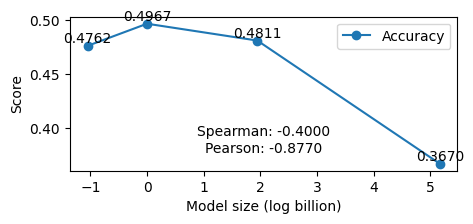

In [93]:
inputs, results = load_data("sampled_negated_lama")
probs, accs = compute_stats(inputs, results)
plot_curve(probs, accs)

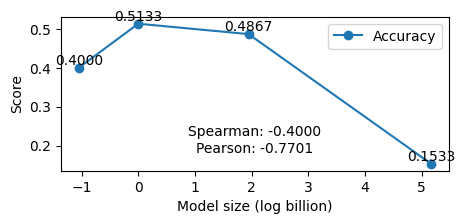

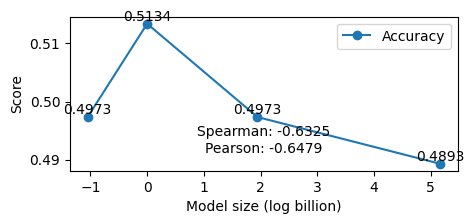

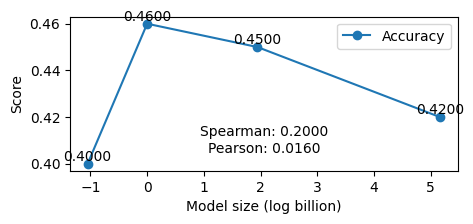

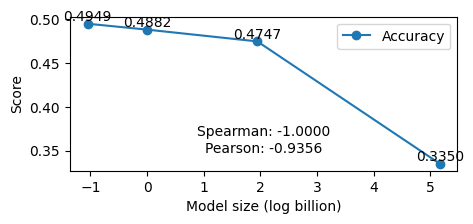

In [94]:
inputs, results = load_data("sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "ConceptNet")
plot_curve(probs, accs)

inputs, results = load_data("sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "GoogleRE")
plot_curve(probs, accs)

inputs, results = load_data("sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "SQUAD")
plot_curve(probs, accs)

inputs, results = load_data("sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "TREx")
plot_curve(probs, accs)

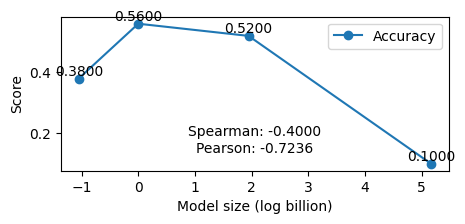

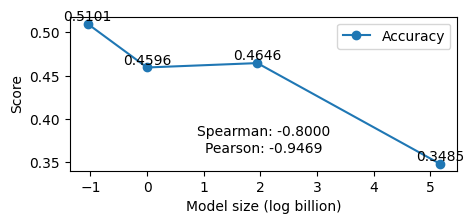

In [98]:
inputs, results = load_data("sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "ConceptNet" and x["metadata"]["category"] == "high_ranked")
plot_curve(probs, accs)

# inputs, results = load_data("sampled_negated_lama")
# probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "GoogleRE" and x["metadata"]["category"] == "high_ranked")
# plot_curve(probs, accs)

# inputs, results = load_data("sampled_negated_lama")
# probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "SQUAD" and x["metadata"]["category"] == "high_ranked")
# plot_curve(probs, accs)

inputs, results = load_data("sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "TREx" and x["metadata"]["category"] == "high_ranked")
plot_curve(probs, accs)

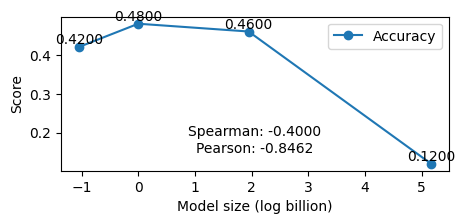

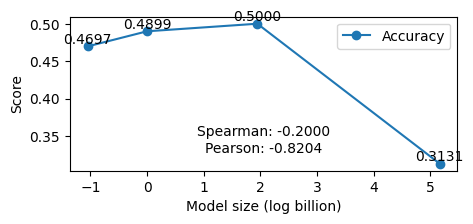

In [99]:
inputs, results = load_data("sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "ConceptNet" and x["metadata"]["category"] == "low_ranked")
plot_curve(probs, accs)

# inputs, results = load_data("sampled_negated_lama")
# probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "GoogleRE" and x["metadata"]["category"] == "low_ranked")
# plot_curve(probs, accs)

# inputs, results = load_data("sampled_negated_lama")
# probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "SQUAD" and x["metadata"]["category"] == "low_ranked")
# plot_curve(probs, accs)

inputs, results = load_data("sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "TREx" and x["metadata"]["category"] == "low_ranked")
plot_curve(probs, accs)

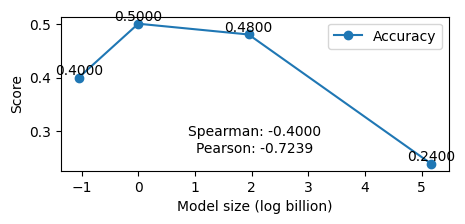

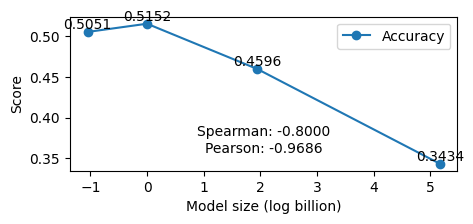

In [100]:
inputs, results = load_data("sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "ConceptNet" and x["metadata"]["category"] == "random")
plot_curve(probs, accs)

# inputs, results = load_data("sampled_negated_lama")
# probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "GoogleRE" and x["metadata"]["category"] == "random")
# plot_curve(probs, accs)

# inputs, results = load_data("sampled_negated_lama")
# probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "SQUAD" and x["metadata"]["category"] == "random")
# plot_curve(probs, accs)

inputs, results = load_data("sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "TREx" and x["metadata"]["category"] == "random")
plot_curve(probs, accs)

# OBQA

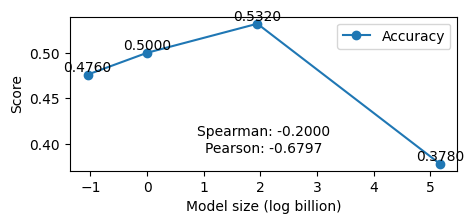

In [88]:
inputs, results = load_data("helm_sampled_data_rebalanced")
probs, accs = compute_stats(inputs, results)
plot_curve(probs, accs)

not/because


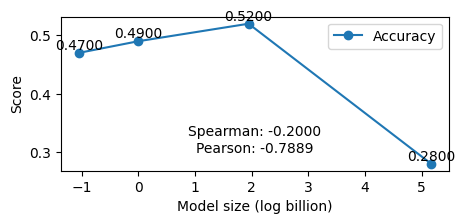

manual/un-in-


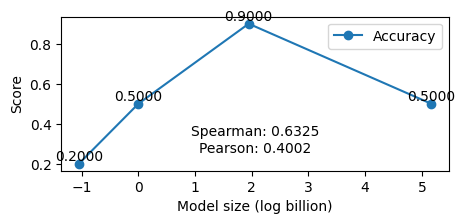

not/do


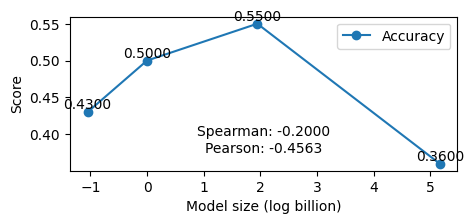

prompt


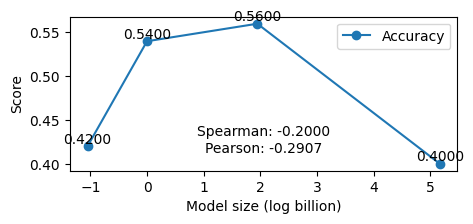

gold/un-in-


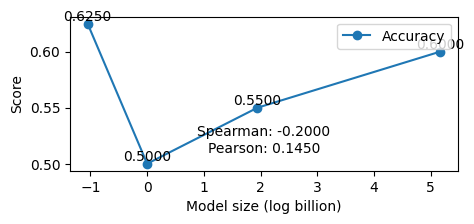

not/be


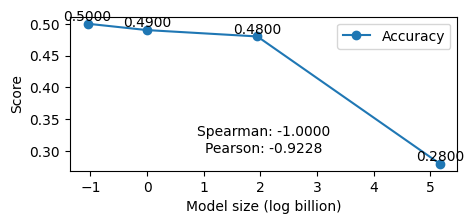

not/modal


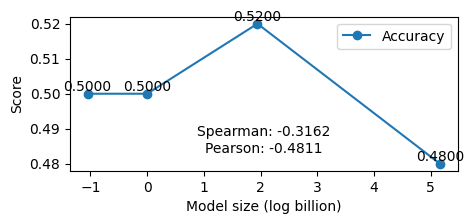

un-in-


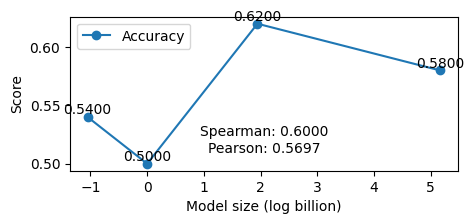

In [90]:
negation_rules = set([item["negation_rule"] for item in inputs])

for rule in negation_rules:
    print(rule)
    inputs, results = load_data("helm_sampled_data_rebalanced")
    probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["negation_rule"] == rule)
    plot_curve(probs, accs)

print("un-in-")
inputs, results = load_data("helm_sampled_data_rebalanced")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: "un-in-" in x["negation_rule"])
plot_curve(probs, accs)

# Normal LAMA

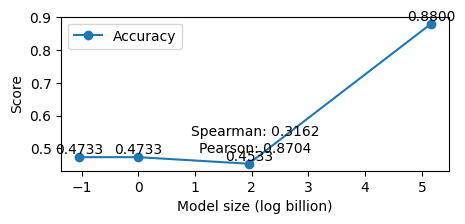

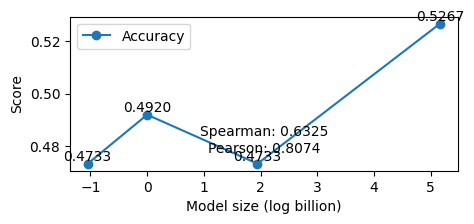

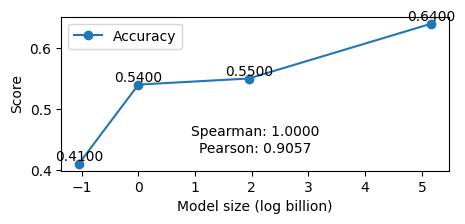

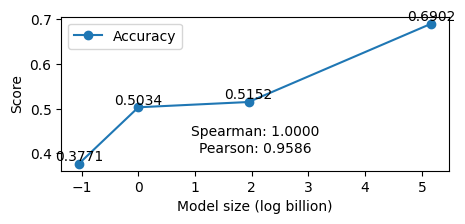

In [2]:
inputs, results = load_data("sampled_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "ConceptNet")
plot_curve(probs, accs)

inputs, results = load_data("sampled_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "GoogleRE")
plot_curve(probs, accs)

inputs, results = load_data("sampled_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "SQUAD")
plot_curve(probs, accs)

inputs, results = load_data("sampled_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "TREx")
plot_curve(probs, accs)

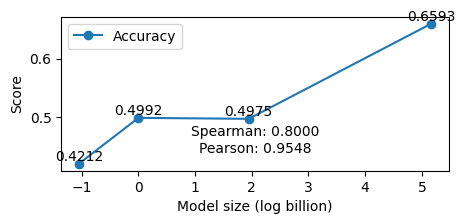

In [3]:
inputs, results = load_data("sampled_lama")
probs, accs = compute_stats(inputs, results)
plot_curve(probs, accs)

# CSQA

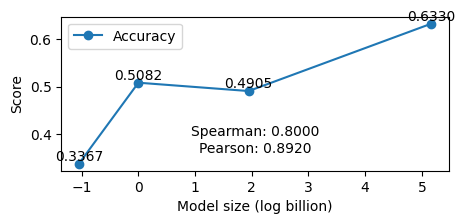

In [5]:
inputs, results = load_data("csqa_gold_no")
probs, accs = compute_stats(inputs, results)
plot_curve(probs, accs)

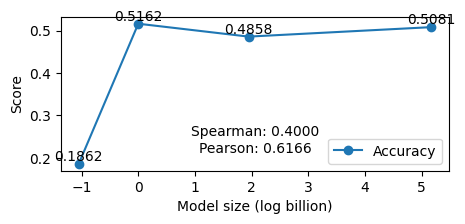

In [7]:
inputs, results = load_data("csqa2_gold_no")
probs, accs = compute_stats(inputs, results)
plot_curve(probs, accs)

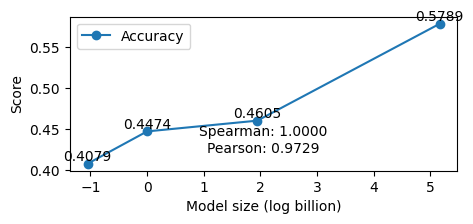

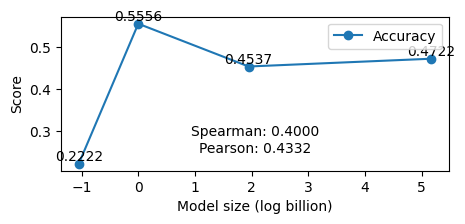

In [13]:
inputs, results = load_data("csqa_gold_no")
probs, accs = compute_stats(inputs, results, lambda x: "is not" in x["question"]["stem"])
plot_curve(probs, accs)

inputs, results = load_data("csqa2_gold_no")
probs, accs = compute_stats(inputs, results, lambda x: "is not" in x["question"]["stem"])
plot_curve(probs, accs)

In [14]:
inputs, results = load_data("csqa_be_not")
probs, accs = compute_stats(inputs, results)
plot_curve(probs, accs)

FileNotFoundError: [Errno 2] No such file or directory: 'csqa_be_not/commonsense:dataset=openbookqa,method=multiple_choice_joint,model=openai_ada/per_instance_stats.json'

# Misprimed Negated LAMA

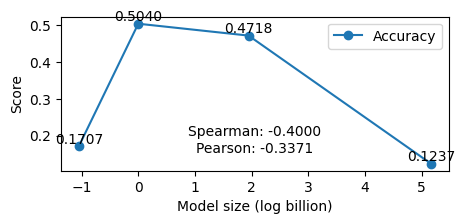

In [3]:
inputs, results = load_data("misprimed_sampled_negated_lama")
probs, accs = compute_stats(inputs, results)
plot_curve(probs, accs)

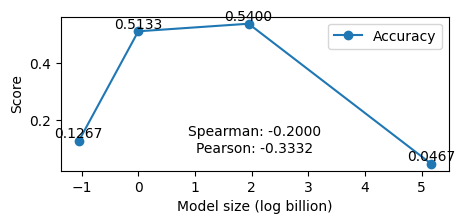

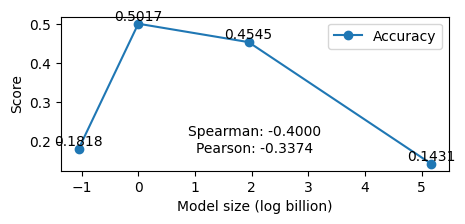

In [4]:
inputs, results = load_data("misprimed_sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "ConceptNet")
plot_curve(probs, accs)

inputs, results = load_data("misprimed_sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "TREx")
plot_curve(probs, accs)

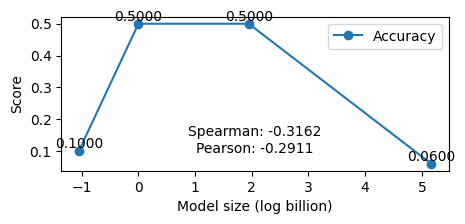

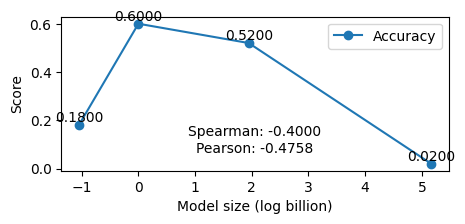

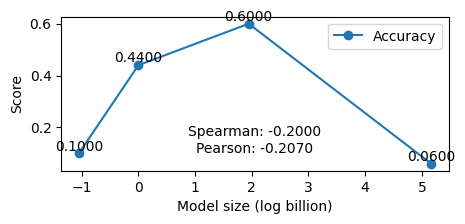

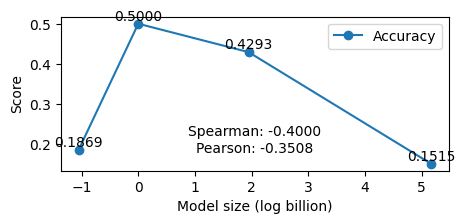

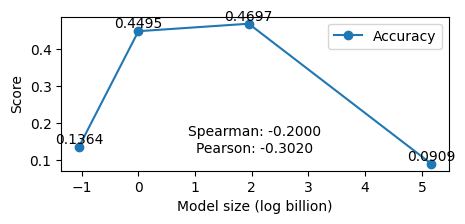

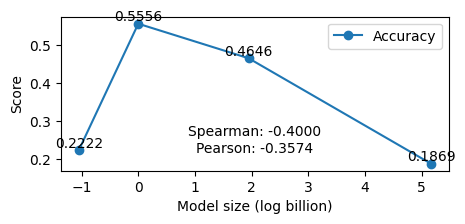

In [6]:
inputs, results = load_data("misprimed_sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "ConceptNet" and x["metadata"]["category"] == "high_ranked")
plot_curve(probs, accs)
inputs, results = load_data("misprimed_sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "ConceptNet" and x["metadata"]["category"] == "low_ranked")
plot_curve(probs, accs)
inputs, results = load_data("misprimed_sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "ConceptNet" and x["metadata"]["category"] == "random")
plot_curve(probs, accs)

inputs, results = load_data("misprimed_sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "TREx" and x["metadata"]["category"] == "high_ranked")
plot_curve(probs, accs)
inputs, results = load_data("misprimed_sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "TREx" and x["metadata"]["category"] == "low_ranked")
plot_curve(probs, accs)
inputs, results = load_data("misprimed_sampled_negated_lama")
probs, accs = compute_stats(inputs, results, filter_fn=lambda x: x["metadata"]["dataset"] == "TREx" and x["metadata"]["category"] == "random")
plot_curve(probs, accs)

# Consistency Analysis

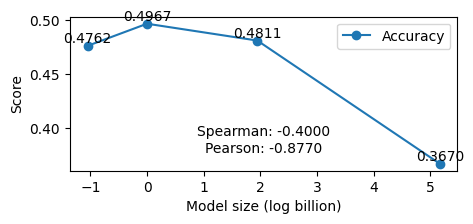

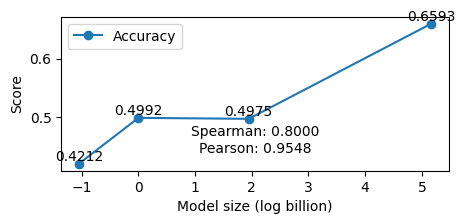

[0.8661740558292282, 0.9080459770114943, 0.8604269293924466, 0.9302134646962233]


In [18]:
inputs, results, predictions_negated = load_data("sampled_negated_lama", return_predictions=True)
probs, accs = compute_stats(inputs, results)
plot_curve(probs, accs)

inputs, results, predictions_original = load_data("sampled_lama", return_predictions=True)
probs, accs = compute_stats(inputs, results)
plot_curve(probs, accs)

consistencies = [(np.array(predictions_negated[i]) == np.array(predictions_original[i])).mean() for i in range(len(predictions_negated))]
print(consistencies)

In [13]:
results[0]

{'question': {'stem': 'Drums is not made of ___?',
  'choices': [{'text': 'wood', 'label': 'A'},
   {'text': 'steel', 'label': 'B'}]},
 'answerKey': 'B',
 'metadata': {'dataset': 'ConceptNet',
  'category': 'high_ranked',
  'subdataset': 'ConceptNet.jsonl',
  'idx': 112}}

In [12]:
predictions

[[' B',
  ' B',
  ' F',
  ' B',
  ' A',
  ' B',
  ' B',
  ' B',
  ' noun',
  ' B',
  ' D',
  ' B',
  ' B',
  ' B',
  ' B',
  ' A',
  ' A',
  ' B',
  ' A',
  ' B',
  ' A',
  ' A',
  ' A',
  ' C',
  ' B',
  ' A',
  ' B',
  ' B',
  ' B',
  ' B',
  ' Study',
  ' B',
  ' B',
  ' A',
  ' A',
  ' A',
  ' B',
  ' Sc',
  ' B',
  ' B',
  ' Sword',
  ' A',
  ' B',
  ' Kind',
  ' Depend',
  ' B',
  ' B',
  ' A',
  ' B',
  ' B',
  ' A',
  ' B',
  ' B',
  ' B',
  ' B',
  ' B',
  ' B',
  ' B',
  ' A',
  ' B',
  ' B',
  ' B',
  ' B',
  ' A',
  ' Cr',
  ' A',
  ' A',
  ' B',
  ' B',
  ' A',
  ' B',
  ' A',
  ' A',
  ' A',
  ' A',
  ' Relax',
  ' B',
  ' B',
  ' B',
  ' B',
  ' B',
  ' B',
  ' B',
  ' A',
  ' B',
  ' B',
  ' A',
  ' B',
  ' B',
  ' B',
  ' B',
  ' B',
  ' A',
  ' B',
  ' B',
  ' B',
  ' Dis',
  ' A',
  ' A',
  ' B',
  ' B',
  ' B',
  ' Study',
  ' A',
  ' B',
  ' A',
  ' A',
  ' B',
  ' A',
  ' B',
  ' A',
  ' B',
  ' B',
  ' B',
  ' A',
  ' B',
  ' A',
  ' A',
  ' B',
  ' B',
  ' B',
 

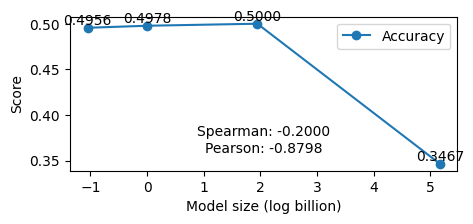

In [20]:
inputs, results = load_data("obqa_original")
probs, accs = compute_stats(inputs, results)
plot_curve(probs, accs)